In [1]:
%load_ext autoreload
%autoreload 2

#See bmes.ahmet/README.txt for instructions to setup and import bmes.
import sys,os; sys.path.append(os.environ['BMESAHMETDIR']); import bmes
sys.path.append(os.environ['BMESAHMETDIR']+'/qsb')
bmes.pipinstall('biopython','Bio')
bmes.pipinstall('GEOparse')
bmes.pipinstall('pandasql')


import GEOparse
import pandas as pd
import numpy

Installing [Bio] (importname=biopython) using [pip] ...
Executing command: c:\ProgramData\Anaconda3\python.exe -m pip install -U Bio

FAILED to install package [Bio], importname [biopython]


## Download and parse GEO data

In [6]:
# TODO: this will download data everytime this section is executed. Can you optimize?
gse = GEOparse.get_GEO(geo="GSE5847", destdir=bmes.tempdir());

12-Apr-2022 15:10:46 DEBUG utils - Directory C:/Users/ahmet/AppData/Local/Temp/bmes already exists. Skipping.
12-Apr-2022 15:10:46 INFO GEOparse - File already exist: using local version.
12-Apr-2022 15:10:46 INFO GEOparse - Parsing C:/Users/ahmet/AppData/Local/Temp/bmes\GSE5847_family.soft.gz: 
12-Apr-2022 15:10:46 DEBUG GEOparse - DATABASE: GeoMiame
12-Apr-2022 15:10:46 DEBUG GEOparse - SERIES: GSE5847
12-Apr-2022 15:10:46 DEBUG GEOparse - PLATFORM: GPL96
12-Apr-2022 15:10:46 DEBUG GEOparse - SAMPLE: GSM136326
12-Apr-2022 15:10:46 DEBUG GEOparse - SAMPLE: GSM136327
12-Apr-2022 15:10:46 DEBUG GEOparse - SAMPLE: GSM136328
12-Apr-2022 15:10:46 DEBUG GEOparse - SAMPLE: GSM136329
12-Apr-2022 15:10:46 DEBUG GEOparse - SAMPLE: GSM136330
12-Apr-2022 15:10:46 DEBUG GEOparse - SAMPLE: GSM136331
12-Apr-2022 15:10:46 DEBUG GEOparse - SAMPLE: GSM136332
12-Apr-2022 15:10:46 DEBUG GEOparse - SAMPLE: GSM136333
12-Apr-2022 15:10:47 DEBUG GEOparse - SAMPLE: GSM136334
12-Apr-2022 15:10:47 DEBUG GEOpars

In [59]:
# Each GSM sample is available in gse.gsms[gsmid]
# Information about each sample is available in gse.gsms[...].metadata
gsm= list(gse.gsms.values())[0]
gsm.metadata

{'title': ['LCM stroma sample from patient #37'],
 'geo_accession': ['GSM136326'],
 'status': ['Public on Sep 30 2007'],
 'submission_date': ['Sep 15 2006'],
 'last_update_date': ['Feb 17 2016'],
 'type': ['RNA'],
 'channel_count': ['1'],
 'source_name_ch1': ['human breast cancer stroma'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['diagnosis: IBC', 'status: Deceased'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': ['PicoPure kit (Arcturus)'],
 'label_ch1': ['biotin'],
 'label_protocol_ch1': ['Small Sample Labeling Protocol vII from Affymetrix'],
 'hyb_protocol': ['Standard Affy protocol'],
 'scan_protocol': ['Standard Affy protocol'],
 'description': ['Chemo: Yes, ER: NEG, Her2Neu: NEG, Stage: IIIA, Clinical IBC: No'],
 'data_processing': ['RMA'],
 'platform_id': ['GPL96'],
 'contact_name': ['Stefan,,Ambs'],
 'contact_laboratory': ['LHC'],
 'contact_institute': ['NCI'],
 'contact_address': ['37 Convent Dr Bldg 37 Room 3050'],
 'conta

In [68]:
# Data for each GSM is available in gse.gsms[...].table

# Combine GSM's into a single data table.
gsedata = None
#Iibc = initialize to a vector of false.
for gsmid in gse.gsms.keys():
    #if gse.gsms[gsmid]['characteristics_ch1'][0]=='diagnosis: IBC': Iibc[..] = true;
    gsmdata = gse.gsms[gsmid].table.rename(columns={'VALUE':gsmid});
    if gsedata is None: gsedata=gsmdata;
    else:
        assert(gsedata['ID_REF'].equals(gsmdata['ID_REF'])) #just make sure that the same probes are listed in the same order.
        gsedata = pd.concat([gsedata,gsmdata[gsmid]],axis=1);

gsedata = gsedata.set_index('ID_REF')
gsedata.head()

GSM136326  GSM136327  GSM136328  GSM136329  GSM136330  GSM136331  \
ID_REF                                                                        
1007_s_at  10.450276   9.399542   9.424799   9.472922   9.278780   9.434428   
1053_at     5.719466   4.849293   4.732081   4.728854   5.326392   5.230320   
117_at      5.938664   6.083273   6.447978   6.176949   6.544585   6.077795   
121_at      8.023052   7.894659   8.344988   8.163204   8.233756   7.595106   
1255_g_at   3.954803   3.963246   3.964102   4.087836   3.998893   3.839705   

           GSM136332  GSM136333  GSM136334  GSM136335  ...  GSM136411  \
ID_REF                                                 ...              
1007_s_at   9.924859   9.561787   9.745115   9.508479  ...  10.679646   
1053_at     5.215126   4.834023   4.877629   5.033619  ...   5.684671   
117_at      6.293336   6.206549   5.916959   6.633561  ...   6.418576   
121_at      7.916302   7.927066   8.032575   7.908482  ...   8.253583   
1255_g_at   4.058756   3.958660   4.118736   4.025031  ...   4.143628   

           GSM136412  GSM136413  GSM136414  GSM136415  GSM136416  GSM136417  \
ID_REF                                                                        
1007_s_at   9.804469  10.562347  10.792802  10.250198  10.762713  10.560312   
1053_at     5.726441   5.731007   5.646109   5.690716   5.873947   5.630389   
117_at      6.725075   6.420450   6.504424   6.602684   6.698563   6.424410   
121_at      8.475521   8.177014   8.327302   8.275579   8.378434   8.430819   
1255_g_at   4.231317   4.117592   4.229090   4.182036   4.102979   4.178124   

           GSM136418  GSM136419  GSM136420  
ID_REF                                      
1007_s_at  10.757617  10.888868  10.772049  
1053_at     5.527384   6.216526   6.076195  
117_at      6.426399   6.494861   6.258779  
121_at      8.403584   8.691069   8.250358  
1255_g_at   4.353376   4.290219   4.107710  

[5 rows x 95 columns]

In [54]:
gplid = list(gse.gpls.values())[0]
print(gplid)

<d: GPL96>


In [69]:
gpl = list(gse.gpls.values())[0].table;
#gpl.head()
gpl[["ID", "Gene Symbol", "Gene Ontology Biological Process", "Gene Ontology Cellular Component", "Gene Ontology Molecular Function"]].head()

ID       Gene Symbol  \
0  1007_s_at  DDR1 /// MIR4640   
1    1053_at              RFC2   
2     117_at             HSPA6   
3     121_at              PAX8   
4  1255_g_at            GUCA1A   

                    Gene Ontology Biological Process  \
0  0001558 // regulation of cell growth // inferr...   
1  0000278 // mitotic cell cycle // traceable aut...   
2  0000902 // cell morphogenesis // inferred from...   
3  0001655 // urogenital system development // in...   
4  0007165 // signal transduction // non-traceabl...   

                    Gene Ontology Cellular Component  \
0  0005576 // extracellular region // inferred fr...   
1  0005634 // nucleus // inferred from electronic...   
2  0005737 // cytoplasm // inferred from direct a...   
3  0005634 // nucleus // inferred from direct ass...   
4  0001750 // photoreceptor outer segment // infe...   

                    Gene Ontology Molecular Function  
0  0000166 // nucleotide binding // inferred from...  
1  0000166 // nucleotide binding // inferred from...  
2  0000166 // nucleotide binding // inferred from...  
3  0000979 // RNA polymerase II core promoter seq...  
4  0005509 // calcium ion binding // inferred fro...

## Show a Clustergram of Expression Values

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


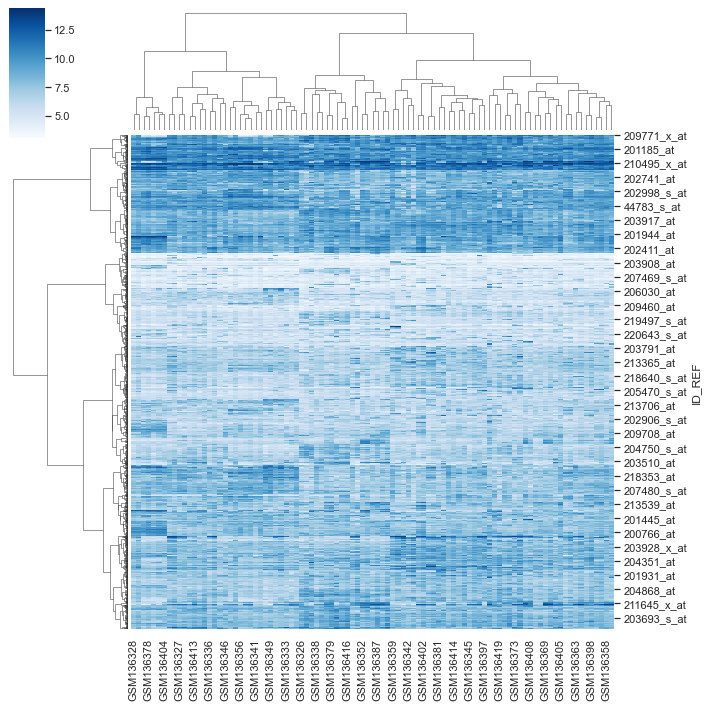

In [90]:
vars = gsedata.var(axis=1) #variances

import numpy
import math
sortedvars = numpy.sort( vars.values )
minvar = sortedvars[ math.floor(sortedvars.size*0.9) ]
d2 = gsedata.drop( gsedata[vars<minvar].index, axis=0)

import seaborn
seaborn.set(style='darkgrid')
clust = seaborn.clustermap(d2, metric="euclidean", method="ward", cmap="Blues")